## La segmentation client R.F.M.  (Récence Fréquence Montant)

In [1]:
# Importer les bibliothèques
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np
import squarify
import warnings
warnings.filterwarnings('ignore')

#### Chargement de la base

In [32]:
# Lire le fichier dans un dataframe pandas
data = pd.read_excel("10K_hypermarche.xls")

#### Un aperçu des 5 premiers et derniers enregistrements:

In [5]:
list(data.columns.values)

['ID ligne',
 'ID commande',
 'Date de commande',
 "Date d'expédition",
 "Mode d'expédition",
 'ID client',
 'Nom du client',
 'Segment',
 'Ville',
 'Région',
 'Pays',
 'Zone géographique',
 'ID produit',
 'Catégorie',
 'Sous-catégorie',
 'Nom du produit',
 'Montant des ventes',
 'Quantité',
 'Remise',
 'Profit']

In [6]:
#data.head()
#data.tail()

#### Observation des données

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
ID ligne              10000 non-null int64
ID commande           10000 non-null object
Date de commande      10000 non-null datetime64[ns]
Date d'expédition     10000 non-null datetime64[ns]
Mode d'expédition     10000 non-null object
ID client             10000 non-null object
Nom du client         10000 non-null object
Segment               10000 non-null object
Ville                 10000 non-null object
Région                10000 non-null object
Pays                  10000 non-null object
Zone géographique     10000 non-null object
ID produit            10000 non-null object
Catégorie             10000 non-null object
Sous-catégorie        10000 non-null object
Nom du produit        10000 non-null object
Montant des ventes    10000 non-null float64
Quantité              10000 non-null int64
Remise                10000 non-null float64
Profit                10000 non-null flo

En regardant la colonne, nous pouvons voir qu'il n'y a pas de Valeurs manquantes.

In [13]:
# Affichage des valeurs nulles
#data.isnull()

In [6]:
data.describe()

,ID ligne,Montant des ventes,Quantité,Remise,Profit
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,293.808906,3.777300,0.103105,37.282974
std,2886.89568,486.055635,2.203268,0.174782,178.100384
min,1.00000,2.955000,1.000000,0.000000,-3059.820000
25%,2500.75000,49.462500,2.000000,0.000000,1.320000
50%,5000.50000,119.355000,3.000000,0.000000,14.220000
75%,7500.25000,320.708625,5.000000,0.100000,48.510000
max,10000.00000,7958.580000,14.000000,0.850000,3979.080000


Ici, nous pouvons observer qu'aucun des clients n'a commandé en quantité négative. Ainsi, nous n'avons pas besoin de filtrer "Quantité" supérieure à zéro.

La fonction describe () dans pandas est pratique pour obtenir diverses statistiques. Cette fonction renvoie le nombre, la moyenne, l'écart type, les valeurs minimales et maximales et les quantiles des données.

#### Suppression des doublons

In [7]:
filtered_data=data[['Pays','ID client']].drop_duplicates()

In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3209 entries, 0 to 9990
Data columns (total 2 columns):
Pays         3209 non-null object
ID client    3209 non-null object
dtypes: object(2)
memory usage: 75.2+ KB


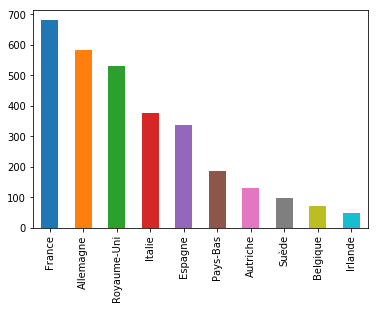

In [9]:
#Top 10 pays
filtered_data.Pays.value_counts()[:10].plot(kind='bar')

Dans l'ensemble de données, on peut observer que la plupart des clients viennent de la "France". Ainsi, on peut filtrer les données pour le client France.

### Construction de la table RFM

Ici, on filtre les colonnes nécessaires à l'analyse RFM. 
On n'a besoin que de ses cinq colonnes:
<ol>
<li><b>ID client </b> définira de manière unique les clients.</li>
<li><b>Date de commande </b> aide à calculer la récence d'achat.</li>
<li><b>ID commande </b> aide à compter le nombre de transactions effectuées (fréquence). </li>
<li><b>Montant des ventes </b> des unité achetée par le client.</li>
</ol>


In [33]:
rfm=data[['ID client','Date de commande','ID commande','Montant des ventes']]

In [34]:
data['Date de commande'].min(),data['Date de commande'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2018-12-30 00:00:00'))

Étant donné la dernière date de commande du jeu de données est le 31 Décembre 2018, que nous utiliserons pour calculer la récence.

In [35]:
PRESENT = dt.datetime(2018,12,31)
data['Date de commande'] = pd.to_datetime(data['Date de commande'])

### calcule RFM

Ici, on effectue les opérations suivantes:
<ul>
<li><b>La Récence</b> calculer le nombre de jours entre la date actuelle et la date du dernier achat de chaque client.</li>
<li><b>La fréquence</b> calculer le nombre de commandes pour chaque client.</li>
<li><b>Le Montant</b> calculer la somme du prix d'achat pour chaque client (déja clculer).</li>
</ul>

In [36]:
rfm= data.groupby('ID client').agg({'Date de commande': lambda date: (PRESENT - date.max()).days,
                                        'ID commande': lambda num: len(num),
                                        'Montant des ventes': lambda price: price.sum()})

In [37]:
rfm.columns

Index(['Date de commande', 'ID commande', 'Montant des ventes'], dtype='object')

In [38]:
rfm.columns=['récence','fréquence','montant']

### Table RFM

In [39]:
rfm.head()

,récence,fréquence,montant
ID client,,,
AA-10360,22,21,8941.7520
AA-10390,413,9,2645.4720
AA-10450,6,6,2294.9100
AA-10600,337,9,4277.8650
AA-10915,132,7,1434.6945


### Analyse de la distribution RFM

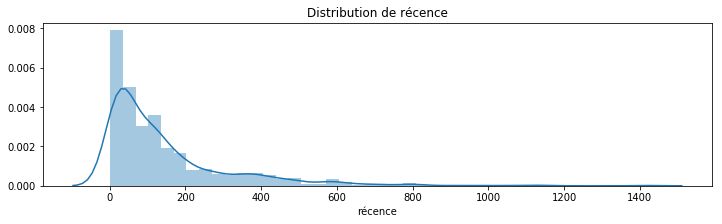

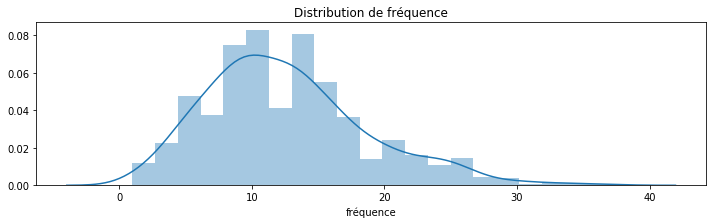

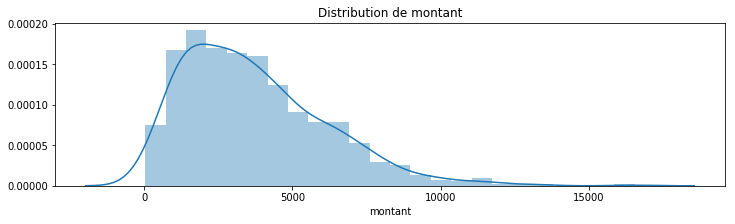

In [24]:
colnames = ['récence', 'fréquence', 'montant']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(rfm[col])
    ax.set_title('Distribution de %s' % col)
    plt.show()

<ul>
<li>La distribution de <b>la récence</b> est asymétrique, ce qui montre que la majorité des clients ont effectué un achat récemment. Il a une longue queue de distribution étalée vers la droite contenant des clients uniques qui ont passé leur commande il y a longtemps.</li>
les distributions de la fréquence et du montant sont pareils asymétrique. 
<li>Le graphique de <b>la fréquence</b> révèle que la majorité des clients a une faible fréquence (petit nombre de commandes, environ 10 par client) et une distribution décalée à gauche de la médiane, et donc une queue de distribution étalée vers la droite contenant des clients beaucoup plus «fidèle» (avec environ 25 achats par client). </li>
<li>Pour <b>le montant</b>, il suit une distribution similaire. La majorité des clients n'a dépensé que peu d'argent mais un une distribution décalée à gauche de la médiane a dépensé beaucoup plus.</li>
</ul>

###  DÉFINIR LES SEGMENTS

### Calcul du quantile des valeurs RFM 

Clients avec la récence la plus basse, la fréquence et le montant les plus élevées sont considérés comme les meilleurs clients.

In [40]:
quartiles = rfm.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      récence  fréquence     montant
0.25     31.0        8.0  1767.93525
0.50     92.0       12.0  3264.97800
0.75    189.0       16.0  5057.61600 <class 'pandas.core.frame.DataFrame'>


In [41]:
quartiles=quartiles.to_dict()
quartiles

{'récence': {0.25: 31.0, 0.5: 92.0, 0.75: 189.0},
 'fréquence': {0.25: 8.0, 0.5: 12.0, 0.75: 16.0},
 'montant': {0.25: 1767.93525, 0.5: 3264.978, 0.75: 5057.616}}

### Calcule de RFM Classe

Pour l'analyse, il est essentiel de combiner les scores pour créer un seul score. Il existe peu d'approches. Une approche consiste à simplement concaténer les scores pour créer un nombre à 3 chiffres entre 111 et 444. Ici, l'inconvénient est trop de catégories (4x4x4). De plus, il n'est pas facile de prioriser des scores comme 421 vs 412.

In [42]:
## pour le Récence

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## pour la fréquence et le montant

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    

In [43]:
rfmSeg = rfm
rfmSeg['R_Quartile'] = rfmSeg['récence'].apply(RClass, args=('récence',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['fréquence'].apply(FMClass, args=('fréquence',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['montant'].apply(FMClass, args=('montant',quartiles,))

In [22]:
rfmSeg.head()

,récence,fréquence,montant,R_Quartile,F_Quartile,M_Quartile
ID client,,,,,,
AA-10360,22,21,8941.7520,1,1,1
AA-10390,413,9,2645.4720,4,3,3
AA-10450,6,6,2294.9100,1,4,3
AA-10600,337,9,4277.8650,4,3,2
AA-10915,132,7,1434.6945,3,4,4


Pour l'analyse, il est essentiel de combiner les scores pour créer un seul score. Il existe peu d'approches. Une approche consiste à simplement concaténer les scores pour créer un nombre à 3 chiffres entre 111 et 444. Ici, l'inconvénient est trop de catégories (4x4x4) Il donne 125 combinaisons (difficiles à représenter et à comprendre) . De plus, il n'est pas facile de prioriser des scores comme 421 vs 412.

### RFMClass

Une autre possibilité consiste à combiner les scores pour créer un score (par exemple, 4 + 1 + 1). Cela créera un score entre 3 et 12. Ici, l'avantage est que chacun des scores a la même importance. Cependant, certains scores auront de nombreux segments (par exemple - 413 et 431)

In [44]:
rfmSeg['RFMClasse'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [24]:
rfmSeg.head()

,récence,fréquence,montant,R_Quartile,F_Quartile,M_Quartile,RFMClasse
ID client,,,,,,,
AA-10360,22,21,8941.7520,1,1,1,111
AA-10390,413,9,2645.4720,4,3,3,433
AA-10450,6,6,2294.9100,1,4,3,143
AA-10600,337,9,4277.8650,4,3,2,432
AA-10915,132,7,1434.6945,3,4,4,344


### Les meilleurs clients

In [55]:
rfmSeg.sort_values(by=['RFMClasse', 'montant'], ascending=[True, False]).head(5)

,récence,fréquence,montant,R_Quartile,F_Quartile,M_Quartile,RFMClasse
ID client,,,,,,,
DB-13315,19,26,13192.7145,1,1,1,111
ZL-21910,4,27,11853.0690,1,1,1,111
BL-11830,7,30,11302.1535,1,1,1,111
DQ-13420,23,24,11159.4420,1,1,1,111
GT-14860,2,31,9938.3550,1,1,1,111


In [50]:
def segment(rows):
    if rows['RFMClasse'] == '111':
        return 'Meilleur client'
    elif rows['RFMClasse'] == '134':
        return 'Presque perdu'
    elif rows['RFMClasse'] == '344':
        return 'Client perdu'
    elif rows['RFMClasse'] == '444':
        return 'Client perdu à petit CA'
    elif rows['RFMClasse'] == '1':
        return 'Client fidèle'
    elif rows['RFMClasse'] == '1':
        return 'Grands dépensiers'
    elif rows['RFMClasse'] == '4':
        return 'Nouveau client'
    else:
        return 'Autres'

In [51]:
rfmSeg['segmentationRFMClasse'] = rfm.apply(segment, axis=1)
rfmSeg.head()

,récence,fréquence,montant,R_Quartile,F_Quartile,M_Quartile,RFMClasse,segmentationRFMClasse
ID client,,,,,,,,
AA-10360,22,21,8941.7520,1,1,1,111,Meilleur client
AA-10390,413,9,2645.4720,4,3,3,433,Autres
AA-10450,6,6,2294.9100,1,4,3,143,Autres
AA-10600,337,9,4277.8650,4,3,2,432,Autres
AA-10915,132,7,1434.6945,3,4,4,344,Client perdu


Text(0.5,1,"Nombre d'apparitions dans l'ensemble de données")

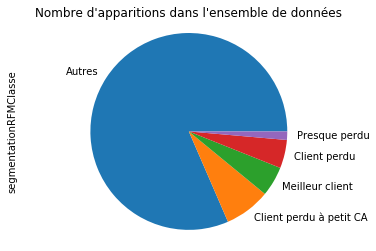

In [22]:
#Graphique en secteurs
rfmSeg.segmentationRFMClasse.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title("Nombre d'apparitions dans l'ensemble de données")

Text(0.5,0,'fréquence')

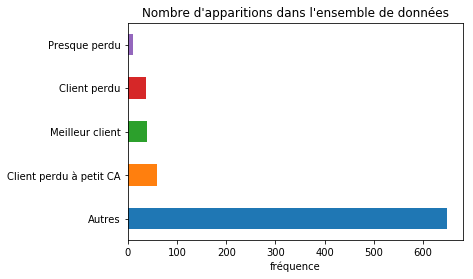

In [23]:
#Plot a histograme des fréquences
rfmSeg.segmentationRFMClasse.value_counts().plot(kind='barh')
plt.title("Nombre d'apparitions dans l'ensemble de données")
plt.xlabel('fréquence')

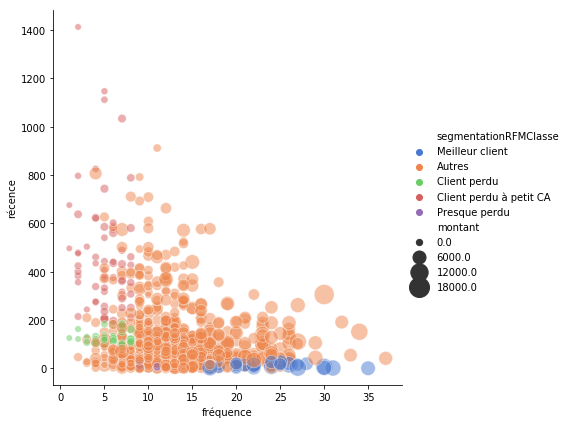

In [59]:
sns.relplot(x="fréquence", y="récence", hue="segmentationRFMClasse", size="montant",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=rfmSeg)

### RFMScore

Une autre possibilité consiste à combiner les scores pour créer un score (par exemple, 4 + 1 + 1). Cela créera un score entre 3 et 12. Ici, l'avantage est que chacun des scores a la même importance. Cependant, certains scores auront de nombreux segments en tant que constituants (par exemple - 413 et 431)

In [62]:
rfmSeg['RFMScore'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']

In [63]:
rfmSeg.head()

,récence,fréquence,montant,R_Quartile,F_Quartile,M_Quartile,RFMClasse,segmentationRFMClasse,id,RFMScore
ID client,,,,,,,,,,
AA-10360,22,21,8941.7520,1,1,1,111,Meilleur client,1,3
AA-10390,413,9,2645.4720,4,3,3,433,Autres,2,10
AA-10450,6,6,2294.9100,1,4,3,143,Autres,3,8
AA-10600,337,9,4277.8650,4,3,2,432,Autres,4,9
AA-10915,132,7,1434.6945,3,4,4,344,Client perdu,5,11


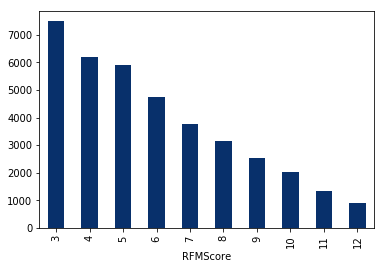

In [65]:
rfmSeg.groupby('RFMScore').agg('montant').mean().plot(kind='bar', colormap='Blues_r')

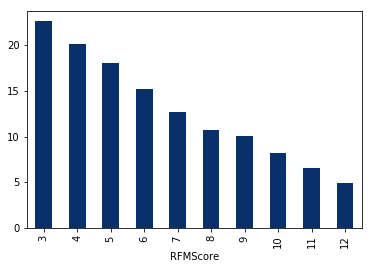

In [66]:
rfmSeg.groupby('RFMScore').agg('fréquence').mean().plot(kind='bar', colormap='Blues_r')

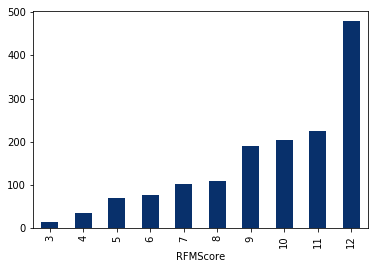

In [67]:
rfmSeg.groupby('RFMScore').agg('récence').mean().plot(kind='bar', colormap='Blues_r')

In [68]:
# Configuration du label pour chaque client et ajout de la colonne "Label" au dataframe

label = [0] * len(rfmSeg)

for i in range(0,len(rfmSeg)):

    if rfmSeg['RFMScore'][i] == 12:
        label[i] = "Les clients perdus" # Meilleurs clients, Les clients fidèles, Les clients perdus clients non confirmés
        
    elif rfmSeg['RFMScore'][i] < 12 and rfmSeg['RFMScore'][i]>7 :
        label[i] = "Les clients non confirmés"
        
    elif rfmSeg['RFMScore'][i] >= 7 :  #
        label[i] = "Les clients fidèles"
        
    elif rfmSeg['RFMScore'][i] >= 3:
        label[i] = "Les Meilleurs clients"
        
    #else: label[i] = "Les clients non confirmés"

In [69]:
# Ajout de la colonne "Label" au dataframe

rfmSeg['Label_RFMScore'] = label

In [72]:
# Compter la fréquence des étiquettes.

rfmSeg['Label_RFMScore'].value_counts()

Les clients non confirmés    335
Les Meilleurs clients        282
Les clients fidèles          118
Les clients perdus            60
Name: Label_RFMScore, dtype: int64

In [73]:
rfmSeg.head()

,récence,fréquence,montant,R_Quartile,F_Quartile,M_Quartile,RFMClasse,segmentationRFMClasse,id,RFMScore,Label_RFMScore
ID client,,,,,,,,,,,
AA-10360,22,21,8941.7520,1,1,1,111,Meilleur client,1,3,Les Meilleurs clients
AA-10390,413,9,2645.4720,4,3,3,433,Autres,2,10,Les clients non confirmés
AA-10450,6,6,2294.9100,1,4,3,143,Autres,3,8,Les clients non confirmés
AA-10600,337,9,4277.8650,4,3,2,432,Autres,4,9,Les clients non confirmés
AA-10915,132,7,1434.6945,3,4,4,344,Client perdu,5,11,Les clients non confirmés


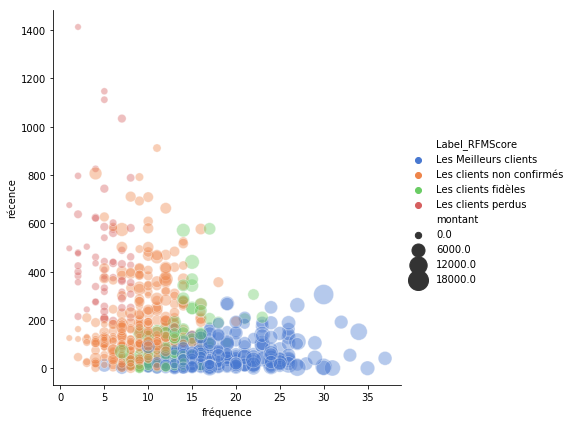

In [74]:
sns.relplot(x="fréquence", y="récence", hue="Label_RFMScore", size="montant",
            sizes=(40, 400), alpha=.4, palette="muted",
            height=6, data=rfmSeg)

### KMeans

In [78]:
rfm=data[['ID client','Date de commande','ID commande','Montant des ventes']]
PRESENT = dt.datetime(2018,12,31)
data['Date de commande'] = pd.to_datetime(data['Date de commande'])
rfm= data.groupby('ID client').agg({'Date de commande': lambda date: (PRESENT - date.max()).days,
                                        'ID commande': lambda num: len(num),
                                        'Montant des ventes': lambda price: price.sum()})
rfm.columns=['récence','fréquence','montant']

In [79]:
X=rfm

La méthode critére du coude nous dit de sélectionner le cluster quand il y a un changement significatif d'inertie. Comme nous pouvons le voir sur le graphique, nous pouvons dire que cela peut être 3 ou 5. Voyons les deux résultats dans le graphique et décidons.

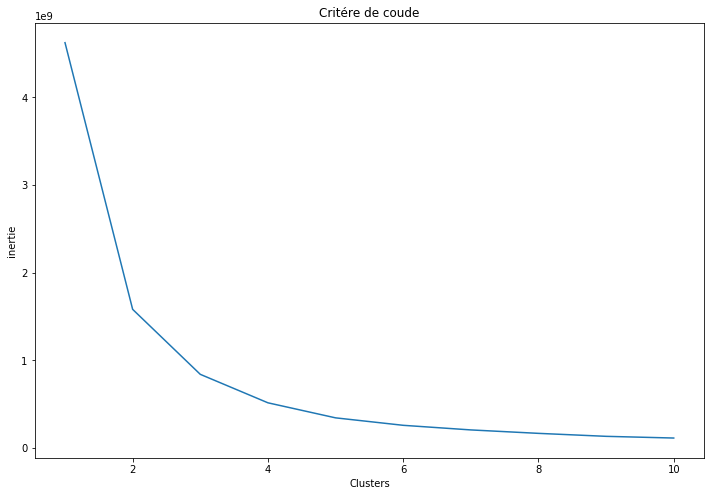

In [80]:
from sklearn.cluster import KMeans
X=rfm
clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Critére de coude')
ax.set_xlabel('Clusters')
ax.set_ylabel('inertie')


plt.show()

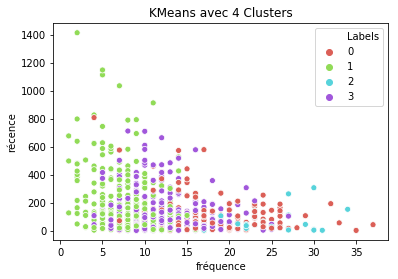

In [219]:
# 4 cluster
km5 = KMeans(n_clusters=4).fit(X)

X['Labels'] = km5.labels_
#plt.figure(figsize=(12, 8))
sns.scatterplot(X['fréquence'], X['récence'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans avec 4 Clusters')
plt.show()

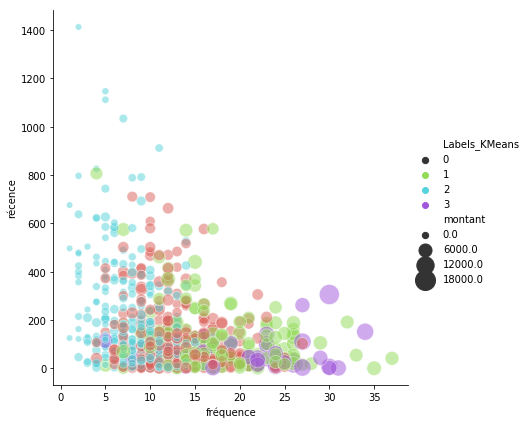

In [81]:
# 4 cluster
km4 = KMeans(n_clusters=4).fit(X)

X['Labels_KMeans'] = km4.labels_
sns.relplot(x="fréquence", y="récence", hue=X['Labels_KMeans'], size="montant",
            sizes=(40, 400), alpha=.5,palette=sns.color_palette('hls', 4),
            height=6, data=X)

On peut analyser nos 5 clusters en détail maintenant:

Cluster 2 représente les Clients qui ont acheté récemment plusieurs fois et dont les dépenses sont les plus élevées.
cluster 3 indique la plus grande parties des clients qui ont achété récemment et de dépenses moyennes et dont la fréquence et entre faible et moyenne.


## creation des segments selon des régles

Dans cette partie nous allons segmentez les clients en fonction d'un ensemble de règles appliquées aux scores R-F-M. On crée 10 groupes, tels que "champions", "need attention" ou "à At risk"

In [28]:
df=data

In [14]:
#rfm['date_de_commande'] = pd.to_datetime(rfm['date_de_commande'])

In [30]:
from datetime import datetime
# Analysis as of: 2015-01-31 (max order date in the dataset: 2014-12-31)
today = datetime.strptime('2018-12-31', '%Y-%m-%d')

In [32]:
agg_dict1 = {
    'ID commande': 'count',
    'Date de commande': 'max',
    'Montant des ventes': 'sum'
}
df_rfm = df.groupby('ID client').agg(agg_dict1).reset_index()
df_rfm.columns = ['ID client', 'fréquence', 'max_date', 'montant']
df_rfm['récence'] = (today - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis=1, inplace=True)


In [33]:

r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

df_rfm['r_score'] = pd.qcut(df_rfm['récence'], q=5, labels=r_labels).astype(int)
df_rfm['f_score'] = pd.qcut(df_rfm['fréquence'], q=5, labels=f_labels).astype(int)
df_rfm['m_score'] = pd.qcut(df_rfm['montant'], q=5, labels=m_labels).astype(int)

df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [34]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [36]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'new customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'about to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'at risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'hibernating')

Ici, on effectue les opérations suivantes:
<ul>
<li><b>Champions</b> : ont acheté récemment, achètent souvent et dépensent le plus.</li>
<li><b>Loyal Customers</b> : dépensent beaucoup d'argent.</li>
<li><b>Potential Loyalist</b> : clients récents, mais a dépensé beaucoup et acheté plus d'une fois.</li>
<li><b>New Customers</b> : ont acheté le plus récemment, mais pas souvent.</li>
<li><b>Promising</b> : mais qui n'ont pas dépensé beaucoup.</li>
<li><b>Needing Attention</b> : récence, fréquence et montant supérieures à la moyenne; peut ne pas avoir acheté très récemment.</li>
<li><b>About To Sleep</b> : en dessous de la moyenne de marécence ,la fréquence et du montant; on les perdra si on ne les réactives pas.</li>
<li><b>At Risk</b> : a dépensé beaucoup d'argent et a acheté il y a souvent mais longtemps; on doit les les réamener.</li>
<li><b>Can't Loose Them</b> : ils ont fait souvent les plus gros achats, mais il ne sont pas retourné depuis longtemps.</li>
<li><b>Hibernating </b> : dernier achat depuis longtemps, faibles dépenses et faible nombre de commandes.</li>
</ul>


### Distribution de la récence, la fréquence et le montant

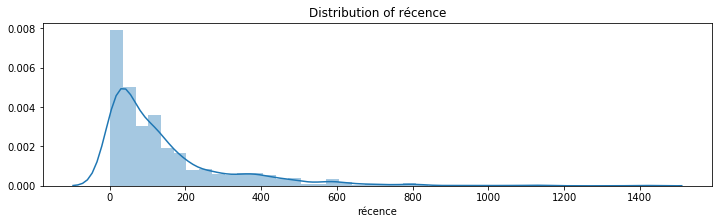

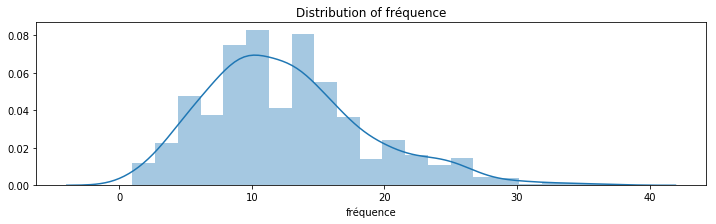

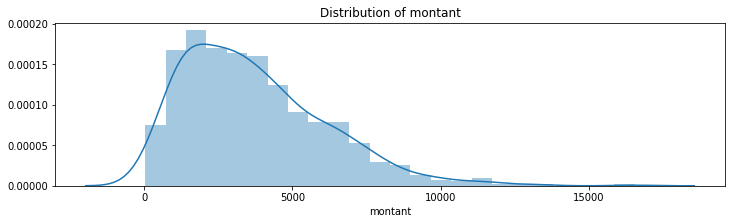

In [40]:
colnames = ['récence', 'fréquence', 'montant']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(df_rfm[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

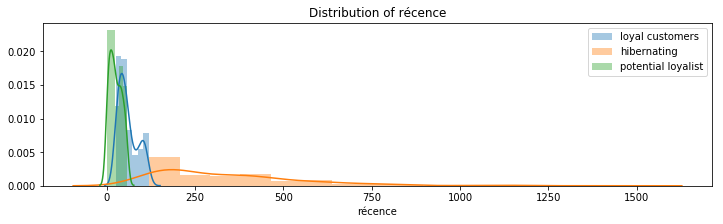

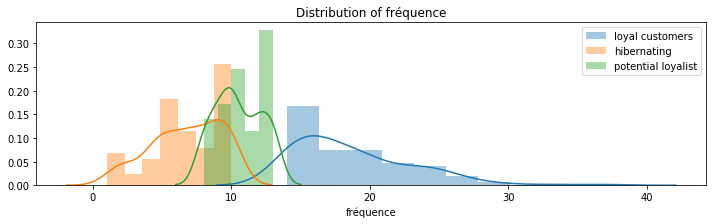

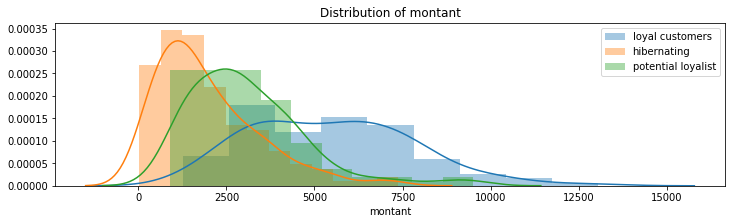

In [83]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

Les distributions de la fréquence et le montant montrent qu'il existe des différences visibles entre les groupes de clients. En examinant la distribution des trois segments les plus importants: "loyal customers", "hibernating", "potential loyalist", il est facile de voir qu’en effet, ils constituent différentes parties de la distribution totale, par exemple. les clients en hibernation sont responsables du premier pic monétaire et les clients fidèles du deuxième pic.

### Analyse des segments

L'analyse des clusters obtenues en concatenant les scores RFM montre que leurs tailles sont assez similaires. Il y a un pic autour du score = 9 qui montre que le groupe de clients des segments 8-10 est nombreux - ce sont les clients qui génèrent des revenus stables et significatifs. Le plus petit segment est pour le score RFM = 15 - c'est compréhensible car ce sont les plus précieux de la clientèle. Bien que ce soit le plus petit groupe, il est encore assez grand.

L'analyse des grappes basée sur l'ensemble de règles appliquées aux scores R-F-M est beaucoup plus diversifiée. Il est bon de voir que les «loyal customers» 17% et les «Potential Loyalist» 15% constituent environ 1/3 de tous les clients (générant près de la moitié des ventes 40%). De plus, il existe un groupe fort de «Champions» qui sont les clients les plus rentables (10% de tous les clients générant 15% de toutes les ventes). En même temps, il faut s'inquiéter du fait que le groupe d '«hibernation» soit si important - plus du quart de tous les clients. Il est possible qu'une partie de ce groupe soit réactivée par une campagne de sensibilisation. Par ailleurs, l'entreprise devrait se concentrer sur le groupe «at risk» pour augmenter la fidélisation de sa clientèle (ils génèrent 15,5% du chiffre d'affaires total).

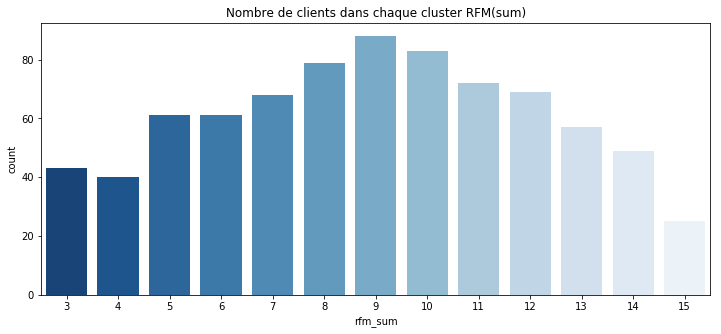

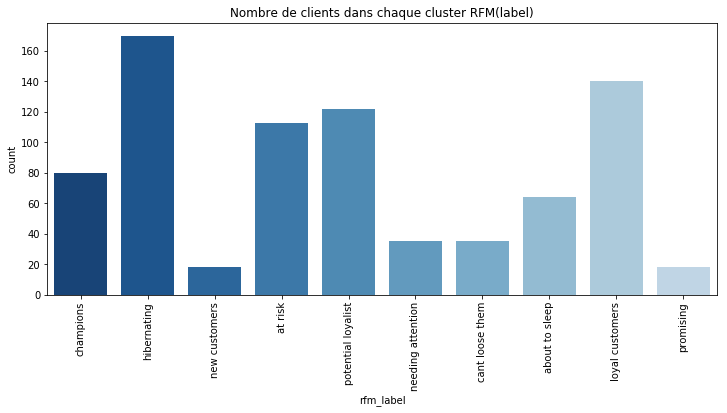

In [53]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['sum', 'label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    ax.set_title('Nombre de clients dans chaque cluster RFM(%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

In [43]:
agg_dict2 = {
    'ID client': 'count',
    'récence': 'mean',
    'fréquence': 'mean',
    'montant': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='récence').reset_index()
df_analysis.rename({'rfm_label': 'label', 'ID client': 'count'}, axis=1, inplace=True)
df_analysis['count_part'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['montant_part'] = df_analysis['montant'] / df_analysis['montant'].sum()
df_analysis['montant'] = df_analysis['montant'] / df_analysis['count']

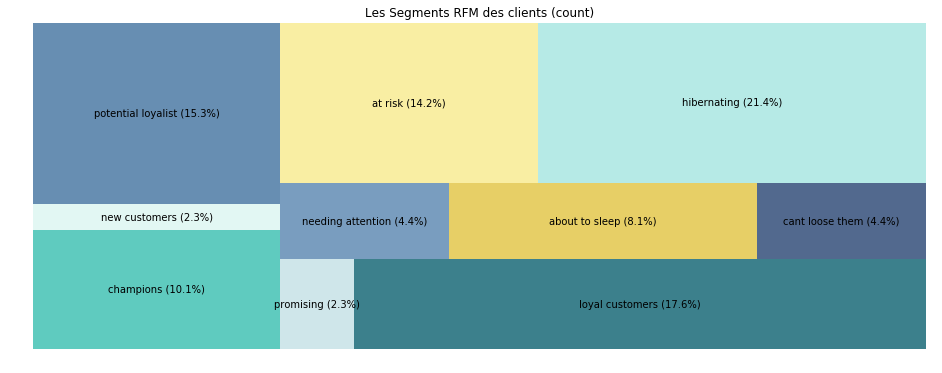

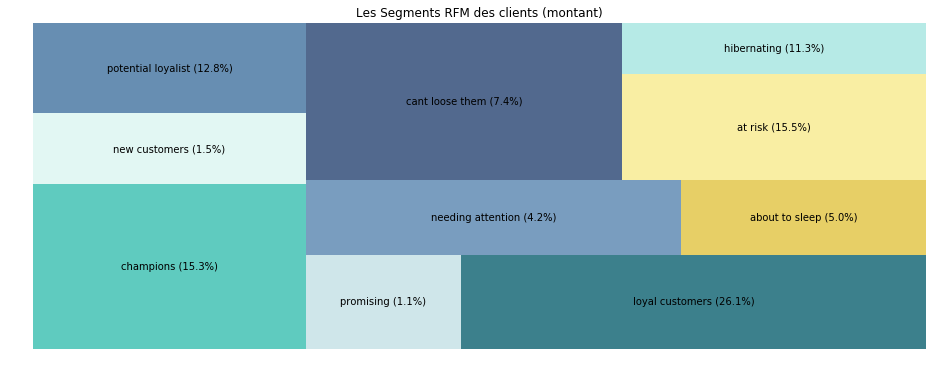

In [52]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'montant']:
    labels = df_analysis['label'] + df_analysis[col + '_part'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('Les Segments RFM des clients (%s)' % col)
    plt.axis('off')
    plt.show()

### Analyse comportementale des segments RFM

In [45]:
df = df.merge(df_rfm[['ID client', 'rfm_sum', 'rfm_label']], on='ID client', how='left')

In [50]:
df.corr()

,ID ligne,Montant des ventes,Quantité,Remise,Profit,rfm_sum
ID ligne,1.000000,-0.003972,-0.021099,0.023176,-0.014931,-0.014570
Montant des ventes,-0.003972,1.000000,0.345116,-0.016923,0.472645,0.068243
Quantité,-0.021099,0.345116,1.000000,0.000939,0.111326,0.028458
Remise,0.023176,-0.016923,0.000939,1.000000,-0.339153,0.007118
Profit,-0.014931,0.472645,0.111326,-0.339153,1.000000,0.036914
rfm_sum,-0.014570,0.068243,0.028458,0.007118,0.036914,1.000000


In [46]:
agg_dict4 = {
    'ID produit': 'count',
    'Quantité': 'sum',
    'Montant des ventes': 'sum',
    'Remise': 'sum',
    'Profit': 'sum',
    'rfm_sum': 'first',
    'rfm_label': 'first'
}

df_order = df.groupby('ID commande').agg(agg_dict4).reset_index()
df_order_segment = df_order.groupby('rfm_label')[['Quantité', 'Montant des ventes', 'Remise', 'Profit', 'rfm_sum']].mean().reset_index()

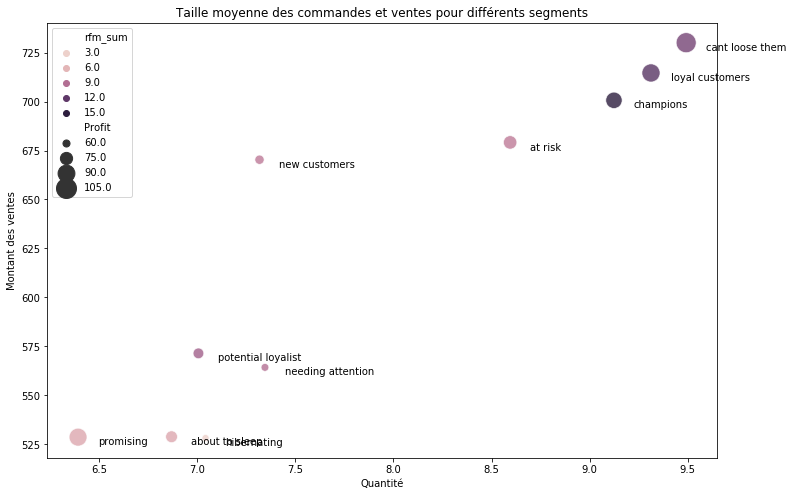

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
plot = sns.scatterplot(x='Quantité', y='Montant des ventes', data=df_order_segment, size='Profit', sizes=(50,400), hue='rfm_sum', alpha=.8)

for i in range(len(df_order_segment)):
     plot.text(df_order_segment['Quantité'][i]+0.1,
               df_order_segment['Montant des ventes'][i]-4,
               df_order_segment['rfm_label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Taille moyenne des commandes et ventes pour différents segments')
plt.show()

Dans ce plot, examinons l'historique des transactions des clients. La quantité de produits en commande et les ventes sont fortement corrélées les unes aux autres (relation linéaire) - les groupes de clients qui passent des commandes avec de nombreux produits génèrent en même temps de grosses ventes. Cela implique que le prix moyen d'un produit est similaire entre les segments.

Les segments générant les ventes les plus élevées sont: «cant loose them», «loyal customers» et «champions». Ils ont également un score RFM élevé (couleur violet foncé) et ils sont responsables du profit le plus élevé (la plus grande taille du marqueur).

## Comparatif entre les modèles

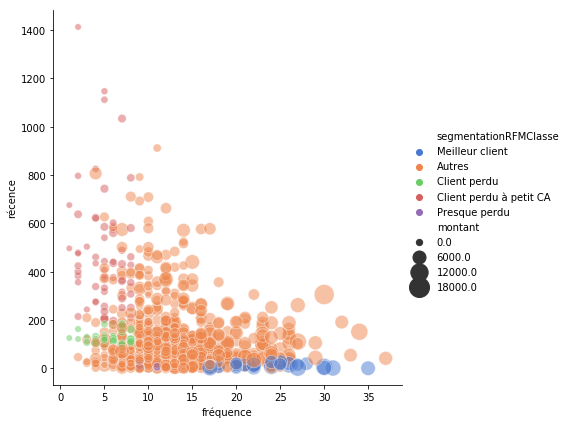

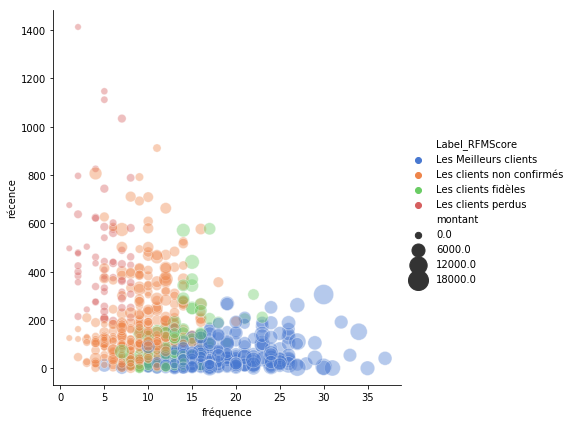

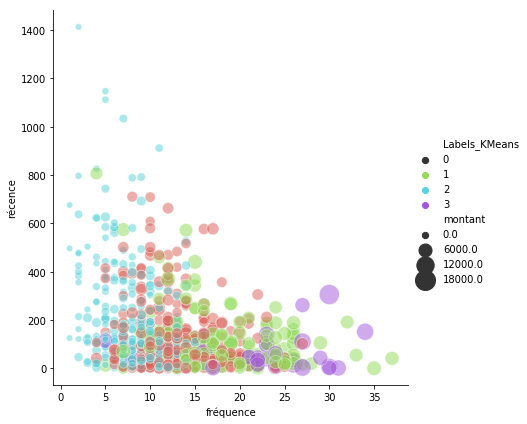

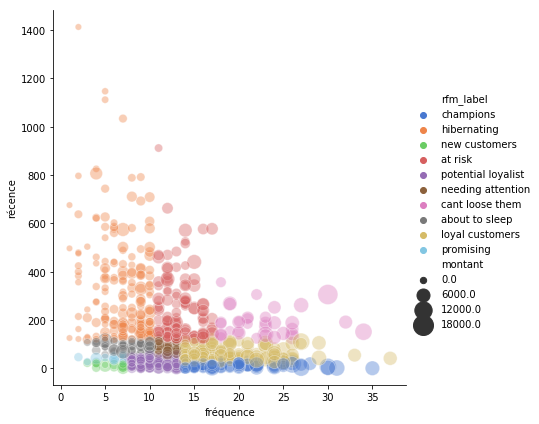

In [82]:
##### RFM Classe #####
sns.relplot(x="fréquence", y="récence", hue="segmentationRFMClasse", size="montant",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=rfmSeg)


##### RFM Score #####
sns.relplot(x="fréquence", y="récence", hue="Label_RFMScore", size="montant",
            sizes=(40, 400), alpha=.4, palette="muted",
            height=6, data=rfmSeg)


##### KMeans #####
# 4 cluster
km4 = KMeans(n_clusters=4).fit(X)

X['Labels_KMeans'] = km4.labels_
sns.relplot(x="fréquence", y="récence", hue=X['Labels_KMeans'], size="montant",
            sizes=(40, 400), alpha=.5,palette=sns.color_palette('hls', 4),
            height=6, data=X)


##### RFM Rules #####
sns.relplot(x="fréquence", y="récence", hue="rfm_label", size="montant",
            sizes=(40, 400), alpha=.4, palette="muted",
            height=6, data=df_rfm)

plt.show()